# A/B test 1 - loved journeys, control vs content similarity sorted list

This related links A/B test (ab1) was conducted from 14-26th Feb 2019.
The data used in this report are 14-18th Feb 2019.

It compared the existing related links (wherhe available) to links generated using Google's universal sentence encoder V2. The first 300 words of content tagged to the topic taxonomy (labelled.csv.gz) were encoded and cosine distance was used to find the nearest vector to each content vector. A maximum of 5 links were suggested and only links above a threshold of 0.15 were suggested. 

16% of labelled content did not recieve any suggested links and 63% of content received 5 suggested links:

| number of suggested links | % pages with this number of links |
|--:|----:|
| 0 | 16% |
| 1 |  8% |
| 2 |  5% |
| 3 | 4%  |
| 4 | 3%  |
| 5 | 63% |

## Import

In [1]:
import os 
import pandas as pd
import numpy as np
import ast
import re

# z test
from statsmodels.stats.proportion import proportions_ztest

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

from scipy import stats
from collections import Counter

# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)

# the number of bootstrap means used to generate a distribution
boot_reps = 10000

# alpha - false positive rate
alpha = 0.05
# number of tests
m = 4
# Correct alpha for multiple comparisons
alpha = alpha / m

# The Bonferroni correction can be used to adjust confidence intervals also. 
# If one establishes m confidence intervals, and wishes to have an overall confidence level of 1-alpha,
# each individual confidence interval can be adjusted to the level of 1-(alpha/m).

# reproducible
seed = 1337

## File/dir locations
### Processed journey data

In [2]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "full_sample_loved_947858.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey",
    filename)
filepath

'/Users/ellieking/Documents/govuk_ab_analysis/data/sampled_journey/full_sample_loved_947858.csv.gz'

In [3]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 710003/710003 [00:15<00:00, 45529.08it/s]


In [4]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)


100%|██████████| 710003/710003 [00:00<00:00, 737902.45it/s]


In [5]:
# drop dodgy rows, where page variant is not A or B. 
df = df.query('ABVariant in ["A", "B"]')

### Nav type of page lookup - is it a finding page? if not it's a thing page

In [6]:
filename = "document_types.csv.gz"

# created a metadata dir in the DATA_DIR to hold this data
filepath = os.path.join(
    DATA_DIR, "metadata",
    filename)
print(filepath)

df_finding_thing = pd.read_csv(filepath, sep="\t", compression="gzip")

df_finding_thing.head()

/Users/ellieking/Documents/govuk_ab_analysis/data/metadata/document_types.csv.gz


,pagePath,is_finding
0,/jobsearch,0
1,/pay-leave-for-parents/y,0
2,/student-finance-calculator/y/2018-2019/uk-full-time,0
3,/government/publications/application-for-confirmation-of-british-nationality-status-form-ns,0
4,/pip/eligibility,0


In [7]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()


finding_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==1]['pagePath'].tolist()

## Outliers
Some rows should be removed before analysis. For example rows with journey lengths of 500 or very high related link click rates. This process might have to happen once features have been created.

## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

### Prepare features

#### Related link prep

In [8]:
def get_number_of_events_rl(event):
    """Counts events with category 'relatedLinkClicked' and action'Related content'."""
    if event[0][0] == 'relatedLinkClicked' and 'Related content' in event[0][1]:
        return event[1]
    return 0


def sum_related_click_events(event_list):
    return sum([get_number_of_events_rl(event) for event in event_list])


def is_related(x):
    """Compute whether a journey includes at least one related link click."""
    return x > 0

In [9]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(sum_related_click_events)

In [10]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Related Links Clicks per seq"].map(is_related)

df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']


In [11]:
df.head(3)

,ABVariant,Page_Event_List,Page_List,Event_cat_act_agg,Occurrences,Page_List_Length,Related Links Clicks per seq,Has_Related,Related Links Clicks row total
0,A,"[(/ check- state- pension, PAGE<:<NULL<:<NULL, other), (/ check- state- pension, PAGE<:<NULL<:<NULL, other), (/workplace-pensions, PAGE<:<NULL<:<NULL, a47819ad-9f57-4976-ac7e-f1586553d3e7,a99fc39c-997a-4b1a-9e6d-8cf63a3100be), (/workplace-pensions, EVENT<:<relatedLinkClicked<:<1.1 Explore the topic, a47819ad-9f57-4976-ac7e-f1586553d3e7,a99fc39c-997a-4b1a-9e6d-8cf63a3100be), (/browse/working/workplace-personal-pensions, PAGE<:<NULL<:<NULL, other), (/browse/working/workplace-personal-pensions,...","[/ check- state- pension, / check- state- pension, /workplace-pensions, /browse/working/workplace-personal-pensions, /plan-retirement-income, /plan-retirement-income/pensions-from-the-government, /state-pension-age, /tax-national-insurance-after-state-pension-age, /national-insurance, /national-insurance/your-national-insurance-number]","[((PAGE_NULL, PAGE_NULL), 10), ((relatedLinkClicked, 1.1 Explore the topic), 1), ((thirdLevelBrowseLinkClicked, 1.7), 1), ((contentsClicked, content_item 4), 1), ((relatedLinkClicked, 1.1 Related content), 1), ((relatedLinkClicked, 1.4 Related content), 1), ((contentsClicked, content_item 2), 1)]",1,10,2,True,2
1,A,"[(/ tell us once, PAGE<:<NULL<:<NULL, other), (/after-a-death/organisations-you-need-to-contact-and-tell-us-once, PAGE<:<NULL<:<NULL, eed5b92e-8279-4ca9-a141-5c35ed22fcf1,f875c256-b84a-417a-b2b5-ff7e301a41c7,0fffa994-b76d-4539-8bf9-2a6c6751580d), (/after-a-death/organisations-you-need-to-contact-and-tell-us-once, EVENT<:<External Link Clicked<:<https://tell-us-someone-died.dwp.gov.uk/death/enrich/recover, eed5b92e-8279-4ca9-a141-5c35ed22fcf1,f875c256-b84a-417a-b2b5-ff7e301a41c7,0fffa994-b76d...","[/ tell us once, /after-a-death/organisations-you-need-to-contact-and-tell-us-once]","[((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://tell-us-someone-died.dwp.gov.uk/death/enrich/recover), 1)]",1,2,0,False,0
2,A,"[(/ vehicle tax, PAGE<:<NULL<:<NULL, other), (/vehicle-tax, PAGE<:<NULL<:<NULL, 1de432b7-2331-4450-9667-374d56e7f084), (/vehicle-tax, EVENT<:<External Link Clicked<:<https://vehicletax.service.gov.uk/, 1de432b7-2331-4450-9667-374d56e7f084)]","[/ vehicle tax, /vehicle-tax]","[((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://vehicletax.service.gov.uk/), 1)]",1,2,0,False,0


### Frequentist statistics

In [12]:
def z_prop(df, col_name):
    """
    Conduct z_prop test and generate confidence interval.

    Using Bernoulli trial terminology where X (or x)
    is number of successes and n is number of trials
    total occurrences, we compare ABVariant A and B.
    p is x/n. We use a z proportion test between variants.
    """
    # A & B
    n = df.Occurrences.sum()
    # prop of journeys with at least one related link, occurrences summed for those rows gives X
    p = df[df[col_name] == 1].Occurrences.sum() / n

    assert (p >= 0), "Prop less than zero!"
    assert (p <= 1), "Prop greater than one!"

    # A
    # number of trials for page A
    n_a = df[df.ABVariant == "A"].Occurrences.sum()
    # number of successes (occurrences), for page A and at least one related link clicked journeys
    x_a = df[(df['ABVariant'] == 'A') & (df[col_name] == 1)].Occurrences.sum()
    # prop of journeys where one related link was clicked, on A
    p_a = x_a / n_a

    # B
    # number of trials for page B
    n_b = df[df.ABVariant == "B"].Occurrences.sum()
    # number of successes for page B, at least one related link clicked
    x_b = df[(df['ABVariant'] == 'B') & (df[col_name] == 1)].Occurrences.sum()
    # prop of journeys where one related link was clicked, on B
    p_b = x_b / n_b

    assert (n == n_a + n_b), "Error in filtering by ABVariant!"

    # validate assumptions
    # The formula of z-statistic is valid only when sample size (n) is large enough.
    # nAp, nAq, nBp and nBq should be ≥ 5.
    # where p is probability of success (we can use current baseline)
    # q = 1 - p

    # tried a helper function here but it didn't work hence not DRY
    assert (n_a * p) >= 5, "Assumptions for z prop test invalid!"
    assert (n_a * (1 - p)) >= 5, "Assumptions for z prop test invalid!"

    assert (n_b * p) >= 5, "Assumptions for z prop test invalid!"
    assert (n_b * (1 - p)) >= 5, "Assumptions for z prop test invalid!"

    # using statsmodels
    # successes
    count = np.array([x_a, x_b])
    # number of trials
    nobs = np.array([n_a, n_b])
    # z prop test
    z, p_value = proportions_ztest(count, nobs, value=0, alternative='two-sided')
    # print(' z-stat = {z} \n p-value = {p_value}'.format(z=z,p_value=p_value))

    statsdict = {'metric_name': col_name, 'stats_method': 'z_prop_test',
                 'x_ab': x_a + x_b, 'n_ab': n, 'p': p,
                 'x_a': x_a, 'n_a': n_a, 'p_a': p_a,
                 'x_b': x_b, 'n_b': n_b, 'p_b': p_b,
                 'test_statistic': z, 'p-value': p_value}

    return statsdict

#### Statistical significance

In [13]:
# help(proportions_ztest)

In [14]:
has_rel = z_prop(df, 'Has_Related')
has_rel

{'metric_name': 'Has_Related',
 'stats_method': 'z_prop_test',
 'x_ab': 62607,
 'n_ab': 1895715,
 'p': 0.033025533901456704,
 'x_a': 34295,
 'n_a': 947857,
 'p_a': 0.0361816181132808,
 'x_b': 28312,
 'n_b': 947858,
 'p_b': 0.02986945301933412,
 'test_statistic': 24.31657756046319,
 'p-value': 1.3092522577415943e-130}

In [15]:
has_rel['p-value'] < alpha

True

#### Practical significance - uplift

In [63]:
print("There was a {0:.2f}% relative change from A to B".format(((has_rel['p_b'] - has_rel['p_a'])/has_rel['p_a'])*100))

There was a -17.45% relative change from A to B


In [17]:
# uplift
def compute_standard_error_prop_two_samples(x_a, n_a, x_b, n_b):
    """
    The standard error of the difference between two proportions is given by the square root of the variances.
    
    The square of the standard error of a proportion is known as the variance of proportion. 
    The variance of the difference between two independent proportions is equal to the sum of the variances of the proportions of each sample. 
    The variances are summed because each sample contributes to sampling error in the distribution of differences.
    
    """
    p1 = x_a/n_a
    p2 = x_b/n_b    
    se = p1*(1-p1)/n_a + p2*(1-p2)/n_b
    return np.sqrt(se)
    
def zconf_interval_two_samples(x_a, n_a, x_b, n_b, alpha=0.05):
    """
    Gives two points, the lower and upper bound of a (1-alpha)% confidence interval.
    
    To calculate the confidence interval we need to know the standard error of the difference between two proportions. 
    The standard error of the difference between two proportions is the combination of the standard error of two independent distributions, ES (p_a) and (p_b).
    
    If the CI includes zero then we accept the null hypothesis at the defined alpha.
    """
    p1 = x_a/n_a
    p2 = x_b/n_b    
    se = compute_standard_error_prop_two_samples(x_a, n_a, x_b, n_b)
    z_critical = stats.norm.ppf(1-0.5*alpha)
    return p2-p1-z_critical*se, p2-p1+z_critical*se


In [18]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = zconf_interval_two_samples(has_rel['x_a'], has_rel['n_a'],
                                           has_rel['x_b'], has_rel['n_b'], alpha = alpha)
print(' difference in proportions = {0:.2f}%'.format(100*(has_rel['x_b']/has_rel['n_b']-has_rel['x_a']/has_rel['n_a'])))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = -0.63%
 95% Confidence Interval = ( -0.70% , -0.57% )


### Bayesian statistics 

Based on [this](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd) blog

To be developed, a Bayesian approach can provide a simpler interpretation.

## count of clicks on navigation elements

There is no statistically significant difference in the count of clicks on navigation elements per journey between page variant A and page variant B.

\begin{equation*}
{\text{total number of navigation element click events from content pages}}
\end{equation*}

### Related link counts

In [19]:
# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

### Navigation events

In [20]:
def is_nav_event(event):
    """
    Return the total number of related links clicks for that row.
    
    Clicks per sequence multiplied by occurrences. 
    """
    return any(
        ['breadcrumbClicked' in event, 'homeLinkClicked' in event,
         all(cond in event for cond in [
             'relatedLinkClicked','Explore the topic'])])


def count_nav_events(page_event_list):
    """Counts the number of nav events from a content page in a Page Event List."""
    content_page_nav_events = 0
    for pair in page_event_list:
        if is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [21]:
# needs finding_thing_df read in from document_types.csv.gz
df['Content_Page_Nav_Event_Count'] = df['Page_Event_List'].progress_map(count_nav_events)

100%|██████████| 710003/710003 [18:47<00:00, 629.44it/s]


In [22]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

In [23]:
df['Content_Search_Event_Count'] = df['Page_List'].progress_map(count_search_from_content)

100%|██████████| 710003/710003 [41:00<00:00, 288.62it/s]


### Generate the derived metric

In [24]:
# count of nav or search clicks
df['Content_Nav_or_Search_Count'] = df['Content_Page_Nav_Event_Count'] + df['Content_Search_Event_Count']
# occurrences is accounted for by the group by bit in our bayesian boot analysis function
df['Content_Nav_Search_Event_Sum_row_total'] = df['Content_Nav_or_Search_Count'] * df['Occurrences']
# required for journeys with no nav later
df['Has_No_Nav_Or_Search'] = df['Content_Nav_Search_Event_Sum_row_total'] == 0

#### Vestigial metric which we dropped

In [25]:
# (nav events + search events) + 1 / related links clicked + 1
# add one to numerator and denominator to avoid undesirable characteristics
# not sure this has great utility as a proxy, seems volatile
# df['Ratio_Nav_Search_to_Rel'] = (df['Content_Nav_Search_Event_Sum_row_total'] + 1) / (df['Related Links Clicks row total'] + 1)
# sns.distplot(df['Ratio_Nav_Search_to_Rel'].values);

This derived variable is problematic, should consider dropping it. Use counts of the numerator instead (as this could be modelled using generalised linear model), as related link clickedness is captured by the earlier metric.

## Temporary df file in case of crash
### Save

In [26]:
# create temp file incase we crash after all that hard work
# uncomment the next cell if you want to save
filepath = os.path.join(
    DATA_DIR, "rl_sampled_processed_journey",
    filename)



In [27]:
# df.to_csv(filepath, sep="\t", compression="gzip", index=False)

### Bayesian bootstrap

In [28]:
def mean_bb(counter_X_keys, counter_X_vals, n_replications):
    """Simulate the posterior distribution of the mean.
    Parameter X: The observed data (array like)
    Parameter n_replications: The number of bootstrap replications to perform (positive integer)
    Returns: Samples from the posterior
    """
    samples = []
    weights = np.random.dirichlet(counter_X_vals, n_replications)
    for w in weights:
        samples.append(np.dot(counter_X_keys, w))
    return samples

In [29]:
def bayesian_bootstrap_analysis(df, col_name=None, boot_reps = 10000, seed = 1337):
    """Run bayesian bootstrap on the mean of a variable of interest between Page Variants.
    
    Args:
        df: A rl_sampled_processed pandas Datframe.
        col_name: A string of the column of interest.

    Returns:
        a_bootstrap: a vector of boot_reps n resampled means from A.
        b_bootstrap: a vector of boot_reps n resampled means from B.
        """
    # grouped by length is vestigial, before this was generalised into a function
    with NumpyRNGContext(seed):
        A_grouped_by_length =  df[df.ABVariant == "A"].groupby(
            col_name).sum().reset_index()
        B_grouped_by_length =  df[df.ABVariant == "B"].groupby(
            col_name).sum().reset_index()
        a_bootstrap = mean_bb(A_grouped_by_length[col_name], 
        A_grouped_by_length['Occurrences'], 
                                 boot_reps)
        b_bootstrap = mean_bb(B_grouped_by_length[col_name], 
                                 B_grouped_by_length['Occurrences'], 
                                 boot_reps)
    
    return a_bootstrap, b_bootstrap

In [64]:
def count_total_searches(df, group):
    searches = df[df.ABVariant == group].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0].reset_index(0)
    total_searches = searches['Content_Nav_or_Search_Count']*searches['Occurrences']
    return sum(total_searches)

def compare_total_searches(df):
    print("total searches in A = {}".format(count_total_searches(df, "A")))
    print("total searches in B = {}".format(count_total_searches(df, "B")))
    percent_diff = abs(count_total_searches(df, "B") - count_total_searches(df, "A"))/(count_total_searches(df, "A")+count_total_searches(df, "B"))*100
    print("B has {0} more navigation or searches than A a {1:.2f}% overall difference".format(count_total_searches(df, "B") - count_total_searches(df, "A"), percent_diff))
    print("The relative change was {0:.2f}% from A to B".format((count_total_searches(df, "B") - count_total_searches(df, "A"))/count_total_searches(df, "A")*100))

In [65]:
compare_total_searches(df)

total searches in A = 57743
total searches in B = 60652
B has 2909 more navigation or searches than A a 2.46% overall difference
The relative change was 5.04% from A to B


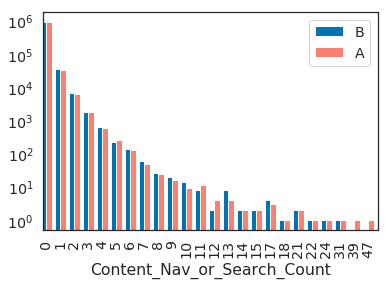

In [32]:
fig, ax = plt.subplots()
plot_df_B = df[df.ABVariant == "B"].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]
plot_df_A = df[df.ABVariant == "A"].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]

ax.set_yscale('log')
width =0.4
ax = plot_df_B.plot.bar(label='B', position=1, width=width)
ax = plot_df_A.plot.bar(label='A', color='salmon', position=0, width=width)

legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [101]:
a_bootstrap, b_bootstrap = bayesian_bootstrap_analysis(df, col_name='Content_Nav_or_Search_Count', boot_reps=boot_reps, seed = seed)

In [102]:
def bb_hdi(a_bootstrap, b_bootstrap, alpha = 0.05):
    """Calculate a 1-alpha high density interval
    
    Args:
        a_bootstrap: a list of resampled means from page A journeys.
        b_bootstrap: a list of resampled means from page B journeys.

    Returns:
        a_ci_low: the lower point of the 1-alpha% highest density interval for A.
        a_ci_hi: the higher point of the 1-alpha% highest density interval for A.
        b_ci_low: the lower point of the 1-alpha% highest density interval for B.
        b_ci_hi: the higher point of the 1-alpha% highest density interval for B.
        ypa_diff_mean: the mean difference for the posterior between A's and B's distributions.
        ypa_diff_ci_low: lower hdi for posterior of the difference.
        ypa_diff_ci_hi: upper hdi for posterior of the difference.
        sorta_p_value: number of values greater than 0 divided by num of obs for mean diff psoterior.
        """
    # Calculate a 95% HDI
    a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap, alpha=alpha)
    # Calculate a 95% HDI
    b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap, alpha=alpha)
    
    # calculate the posterior for the difference between A's and B's mean of resampled means
    # ypa prefix is vestigial from blog post
    ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
    ypa_diff_mean = ypa_diff.mean()
    # get the hdi
    ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)
    # We count the number of values greater than 0 and divide by the total number
    # of observations
    # which returns us the the proportion of values in the distribution that are
    # greater than 0, could act a bit like a p-value
    p_value = (ypa_diff > 0).sum() / ypa_diff.shape[0]

    return {'a_ci_low':a_ci_low, 'a_ci_hi':a_ci_hi, 'b_ci_low':b_ci_low, 'b_ci_hi':b_ci_hi, 'ypa_diff_mean':ypa_diff_mean, 'ypa_diff_ci_low':ypa_diff_ci_low, 'ypa_diff_ci_hi':ypa_diff_ci_hi, 'p_value':p_value}

In [103]:
# ratio is vestigial but we keep it here for convenience
# it's actually a count but considers occurrences
ratio_stats = bb_hdi(a_bootstrap, b_bootstrap, alpha=alpha)
ratio_stats

{'a_ci_low': 0.06004007647500452,
 'a_ci_hi': 0.061773828059300546,
 'b_ci_low': 0.06314592073423679,
 'b_ci_hi': 0.06486937981056697,
 'ypa_diff_mean': 0.003072039469973978,
 'ypa_diff_ci_low': 0.00206071404468236,
 'ypa_diff_ci_hi': 0.003998483404527228,
 'p_value': 1.0}

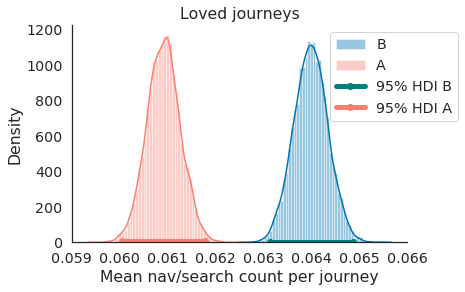

In [108]:
ax = sns.distplot(b_bootstrap, label='B')
ax.errorbar(x=[ratio_stats['b_ci_low'], ratio_stats['b_ci_hi']], y=[2, 2], linewidth=5, c='teal', marker='o', 
         label='95% HDI B')

ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.errorbar(x=[ratio_stats['a_ci_low'], ratio_stats['a_ci_hi']], y=[5, 5], linewidth=5, c='salmon', marker='o', 
         label='95% HDI A')

# ax.set(xlabel='mean Content_Nav_or_Search_Count per session', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True,  bbox_to_anchor=(0.75, 1), loc='best')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("Loved journeys")
plt.xlabel('Mean nav/search count per journey')
plt.ylabel('Density')

plt.savefig('nav_counts_loved.png', dpi = 900, bbox_inches = 'tight')

In [37]:
# calculate the posterior for the difference between A's and B's ratio
# ypa prefix is vestigial from blog post
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

# the mean of the posterior
print('mean:', ypa_diff.mean())

print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

mean: 0.003072039469973978
low ci: 0.00206071404468236 
high ci: 0.003998483404527228


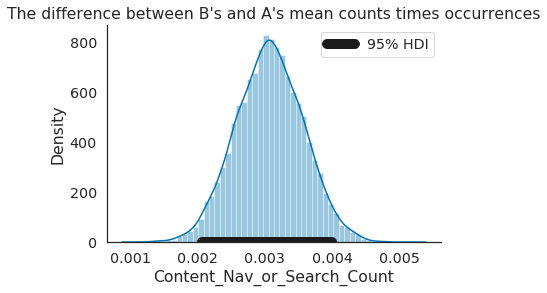

In [38]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Content_Nav_or_Search_Count', ylabel='Density', 
       title='The difference between B\'s and A\'s mean counts times occurrences')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [39]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

1.0

In [40]:
# We count the number of values less than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# less than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.0

In [41]:
(ypa_diff>0).sum()

10000

In [42]:
(ypa_diff<0).sum()

0

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### Overall

In [43]:
# if (Content_Nav_Search_Event_Sum == 0) that's our success
# Has_No_Nav_Or_Search == 1 is a success
# the problem is symmetrical so doesn't matter too much
sum(df.Has_No_Nav_Or_Search * df.Occurrences) / df.Occurrences.sum()

0.9532308390237985

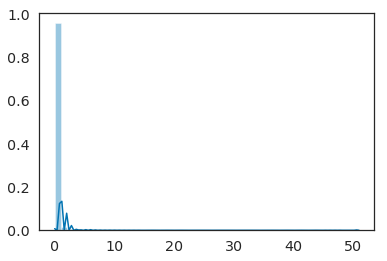

In [44]:
sns.distplot(df.Content_Nav_or_Search_Count.values);

### Frequentist statistics
#### Statistical significance

In [67]:
nav = z_prop(df, 'Has_No_Nav_Or_Search')
nav

{'metric_name': 'Has_No_Nav_Or_Search',
 'stats_method': 'z_prop_test',
 'x_ab': 1807054,
 'n_ab': 1895715,
 'p': 0.9532308390237985,
 'x_a': 904652,
 'n_a': 947857,
 'p_a': 0.9544182297540663,
 'x_b': 902402,
 'n_b': 947858,
 'p_b': 0.9520434495462401,
 'test_statistic': 7.742854829032711,
 'p-value': 9.720901191208409e-15}

#### Practical significance - uplift

In [71]:
# function defined earlier in notebook

# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = zconf_interval_two_samples(nav['x_a'], nav['n_a'],
                                           nav['x_b'], nav['n_b'], alpha = alpha)
diff = 100*(nav['p_b']-nav['p_a'])
print(' difference in proportions = {0:.2f}%'.format(diff))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = -0.24%
 95% Confidence Interval = ( -0.31% , -0.16% )


In [70]:
print("There was a {0: .2f}% relative change in the proportion of journeys not using search/nav elements".format(100 * ((nav['p_b']-nav['p_a'])/nav['p_a'])))

There was a -0.25% relative change in the proportion of journeys not using search/nav elements


In [57]:
nav['x_a']/nav['n_a']

0.9544182297540663

## Average Journey Length (number of page views)
There is no statistically significant difference in the average page list length of journeys (including loops) between page variant A and page variant B.

In [72]:
length_B = df[df.ABVariant == "B"].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthB_2 = length_B.reindex(np.arange(1, 501, 1), fill_value=0)

length_A = df[df.ABVariant == "A"].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthA_2 = length_A.reindex(np.arange(1, 501, 1), fill_value=0)

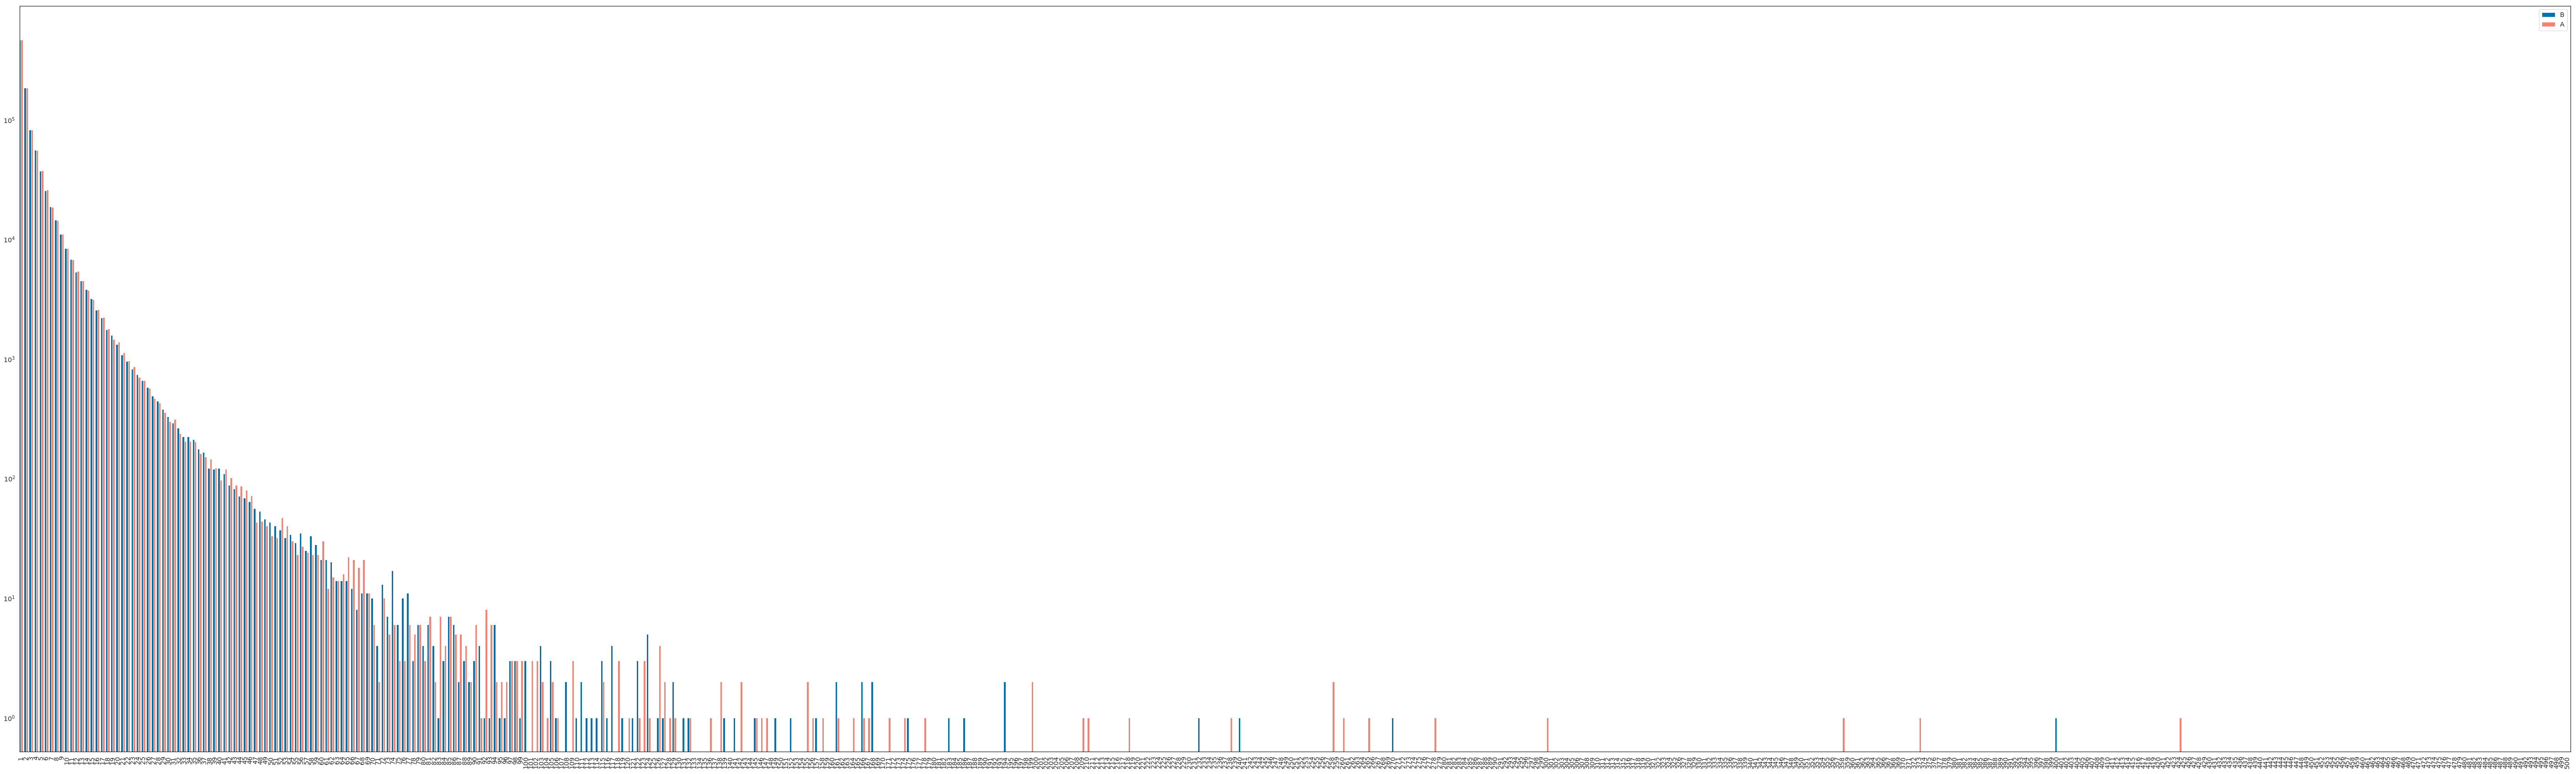

In [73]:
fig, ax = plt.subplots(figsize=(100, 30))

ax.set_yscale('log')
width = 0.4
ax = lengthB_2.plot.bar(label='B', position=1, width=width)
ax = lengthA_2.plot.bar(label='A', color='salmon', position=0, width=width)
plt.xlabel('length', fontsize=1)
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

### Bayesian bootstrap for non-parametric hypotheses

In [74]:
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

In [75]:
# let's use mean journey length (could probably model parametrically but we use it for demonstration here)
# some journeys have length 500 and should probably be removed as they are liekely bots or other weirdness

In [91]:
print("The mean number of pages in an loved jounrey is {0:.3f}".format(sum(df.Page_List_Length*df.Occurrences)/df.Occurrences.sum()))

The mean number of pages in an loved jounrey is 2.992


In [76]:
# for reproducibility, set the seed within this context
a_bootstrap, b_bootstrap = bayesian_bootstrap_analysis(df, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed)

In [89]:
np.array(a_bootstrap).mean()

2.9920895961341643

In [90]:
np.array(b_bootstrap).mean()

2.9922403701211002

In [77]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

low ci: 2.9831085415575465 
high ci: 3.0005559380644846


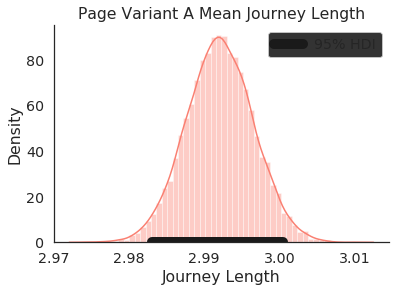

In [78]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.plot([a_ci_low, a_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine()
plt.legend();

In [79]:
# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.983295924865377 
high ci: 3.0009030220876753


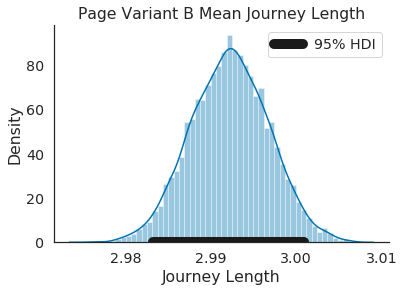

In [80]:
ax = sns.distplot(b_bootstrap)
ax.plot([b_ci_low, b_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant B Mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

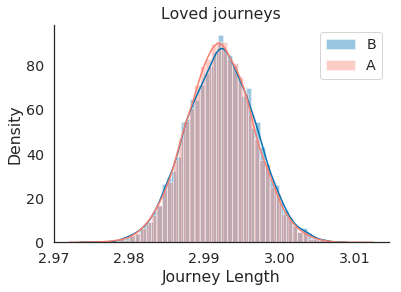

In [93]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("Loved journeys")

plt.savefig('journey_length_loved.png', dpi = 900, bbox_inches = 'tight')

We can also measure the uncertainty in the difference between the Page Variants's Journey Length by subtracting their posteriors.



In [82]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [83]:
# the mean of the posterior
ypa_diff.mean()

0.00015077398693602557

In [84]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: -0.011913268968277269 
high ci: 0.01280197194939836


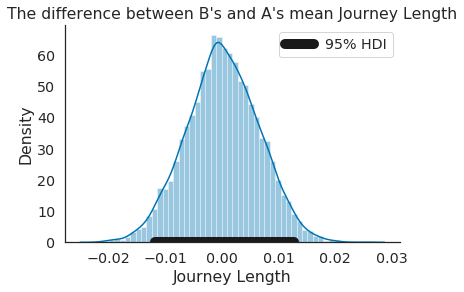

In [85]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', 
       title='The difference between B\'s and A\'s mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can actually calculate the probability that B's mean Journey Length was greater than A's mean Journey Length by measuring the proportion of values greater than 0 in the above distribution.

In [86]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.5062

In [87]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.4938